<a href="https://colab.research.google.com/github/abelowska/eegML/blob/main/Classes_04_nonlinear_regression_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nonlinear regressors and Pipelines


In this notebook you will learn about:
- Scaling data before training with [StandardScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standard+scaler#sklearn.preprocessing.StandardScaler).
- Chaining operations on data with [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) framework.
- [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) regressor with different parameters:
  - kernels: *linear* (linear modelling) and *rbf* (nonlinear modelling).
  - *epsilon* (specifies the epsilon-tube).
  - *C* (regularization parameter).

Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

import io
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
plt.rcParams["figure.figsize"] = (10,7)

In [ ]:
# constans
test_size=0.2 
random_state=42

## Load the Life Expectancy Dataset

In [ ]:
# To upload from your local drive, start with the following code. 
# It will prompt you to select a file. Click on “Choose Files” 
# then select and upload the .csv file you downloaded. 

from google.colab import files
uploaded = files.upload()

Saving Life_Expectancy_Data.csv to Life_Expectancy_Data.csv


In [ ]:
# make sure the filename matches the name of the uploaded file 
life_expectancy_data = pd.read_csv(io.BytesIO(uploaded['Life_Expectancy_Data.csv']))
life_expectancy_df = life_expectancy_data.copy()

In [ ]:
life_expectancy_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [ ]:
# drop NaN values
life_expectancy_df = life_expectancy_df.dropna()            

## Prepare data

In [ ]:
# select BMI and GDP columns
X = life_expectancy_df[[" BMI ", "GDP"]]
X.head()

,BMI,GDP
0,19.1,584.259210
1,18.6,612.696514
2,18.1,631.744976
3,17.6,669.959000
4,17.2,63.537231


In [ ]:
y = life_expectancy_df[["Schooling"]]
y.head()

,Schooling
0,10.1
1,10.0
2,9.9
3,9.8
4,9.5


### Train-test split

In [ ]:
test_size

0.2

In [ ]:
# to ensure repeatability of splits, we set the random state
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=test_size, 
    random_state=random_state
)

In [ ]:
print(f"Shape of the X train dataset: {X_train.shape}")
print(f"Shape of the X test dataset: {X_test.shape}")
print(f"Shape of the y train dataset: {y_train.shape}")
print(f"Shape of the y test dataset: {y_test.shape}")

Shape of the X train dataset: (1319, 2)
Shape of the X test dataset: (330, 2)
Shape of the y train dataset: (1319, 1)
Shape of the y test dataset: (330, 1)


## Model fitting with pre-processing

A range of preprocessing algorithms in scikit-learn allow us to transform the input data before training a model. In our case, we will standardize the data and after that train a model on our scaled dataset. 

### Scaler

In [ ]:
X_train.describe()

,BMI,GDP
count,1319.000000,1319.000000
mean,37.941016,5668.715438
std,19.846596,11971.059185
min,2.000000,1.681350
25%,19.350000,458.876265
50%,43.000000,1536.156850
75%,55.700000,4682.028192
max,77.100000,119172.741800


We see that the dataset’s features span across different ranges. Some algorithms make some assumptions regarding the feature distributions and usually normalizing features will be helpful to address these assumptions.

For normalization we use a `scikit-learn` transformer called [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standard+scaler#sklearn.preprocessing.StandardScaler). This transformer shifts and scales each feature individually so that they all have a 0-mean and a unit standard deviation.

1. First, we have to fit `StandardScaler()` to learn the scaling from the data.

In [ ]:
# create StandarsScaler object
scaler = StandardScaler()

# fit it to the train data
scaler.fit(X_train)

StandardScaler()

The `fit()` method for transformers is similar to the `fit()` method for predictors. The main difference is that the StandardScaler employs *unsupervised learnig*, therefore we don't have to provide target data.

We can inspect the computed means and standard deviations:

In [ ]:
scaler.mean_

array([  37.94101592, 5668.71543752])

In [ ]:
scaler.scale_

array([   19.83907149, 11966.52039479])

2. Once we fitted Scaler to data, we can perform *data transformation* by calling the method `transform()`.

In [ ]:
X_train_scaled = scaler.transform(X_train)

In [ ]:
print(f"Mean of each feature: {np.mean(X_train_scaled, axis=0)}")
print(f"SD of each feature: {np.std(X_train_scaled, axis=0)}")

Mean of each feature: [1.69689888e-16 2.96283931e-17]
SD of each feature: [1. 1.]


Note that Scaler pulled data from the dataframe into an array  when transforming data: 

In [ ]:
type(X_train_scaled)

numpy.ndarray

Let's look into the data:

In [ ]:
X_train_scaled_df = pd.DataFrame(
    X_train_scaled,
    columns=X_train.columns
)

X_train_scaled_df.describe()

,BMI,GDP
count,1.319000e+03,1.319000e+03
mean,1.696899e-16,2.962839e-17
std,1.000379e+00,1.000379e+00
min,-1.811628e+00,-4.735741e-01
25%,-9.370910e-01,-4.353679e-01
50%,2.550011e-01,-3.453434e-01
75%,8.951520e-01,-8.245398e-02
max,1.973831e+00,9.485132e+00


All `scikit-learn` transformers implement methods:
-  `fit()`;
- `transform()`;
- `fit_transform()` which is a shorthand method to call successively fit and then transform. 

We can simplify our code:

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled_df = pd.DataFrame(
    X_train_scaled,
    columns=X_train.columns
)

X_train_scaled_df.describe()

,BMI,GDP
count,1.319000e+03,1.319000e+03
mean,1.696899e-16,2.962839e-17
std,1.000379e+00,1.000379e+00
min,-1.811628e+00,-4.735741e-01
25%,-9.370910e-01,-4.353679e-01
50%,2.550011e-01,-3.453434e-01
75%,8.951520e-01,-8.245398e-02
max,1.973831e+00,9.485132e+00


In [ ]:
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_test_scaled_df = pd.DataFrame(
    X_test_scaled,
    columns=X_test.columns
)

X_test_scaled_df.describe()

,BMI,GDP
count,330.000000,330.000000
mean,0.047254,-0.042879
std,0.977480,0.772142
min,-1.806587,-0.472783
25%,-0.843841,-0.433601
50%,0.403698,-0.329917
75%,0.925395,-0.025188
max,1.762128,4.995368


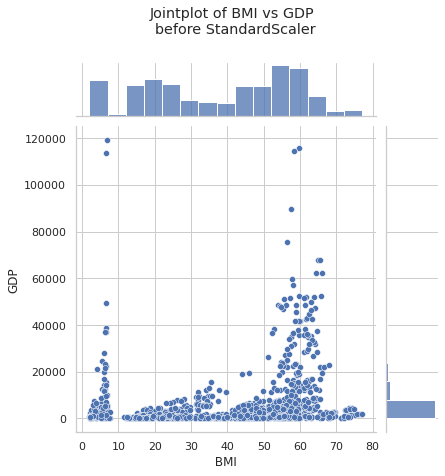

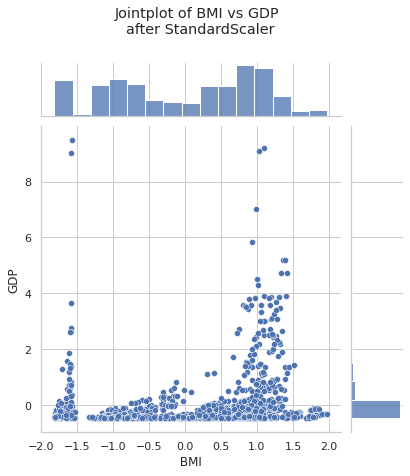

In [ ]:
sns.jointplot(data=X_train, x=" BMI ",
              y="GDP", marginal_kws=dict(bins=15))
plt.suptitle("Jointplot of BMI vs GDP \nbefore StandardScaler", y=1.1)

sns.jointplot(data=X_train_scaled_df, x=" BMI ",
              y="GDP", marginal_kws=dict(bins=15))
_ = plt.suptitle("Jointplot of BMI vs GDP \nafter StandardScaler", y=1.1)

Here are some reasons for scaling features:

- Models that rely on the distance between a pair of samples, for instance k-nearest neighbors, should be trained on normalized features to make each feature contribute approximately equally to the distance computations.

- Many models such as logistic regression use a numerical solver (based on gradient descent) to find their optimal parameters. Such solvers converge faster when the features are scaled.

### Model with Pipeline framework

#### Create Pipeline

We can easily combine sequential operations with a scikit-learn [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), which chains together operations and is used as any other classifier or regressor.

According to the documentation:

> Intermediate steps of the pipeline must be *transforms*, that is, they must implement `fit()` and `transform()` methods. The `fit()` method can be no-operation (empty implementation) when given intermediate step only transform values (e.g. categorical values to numerical ones). The final estimator only needs to implement `fit()`. 



In [ ]:
scaler = StandardScaler()
lm = linear_model.LinearRegression()

Pipeline input is a *steps* list -  a **list** of (name, transformer) **tuples** (implementing fit/transform).

In [ ]:
# define steps
steps = [
    ('scaler', scaler), 
    ('lm', lm)
]

# create pipeline from steps list
pipe = Pipeline(steps)

Visualize the pipeline

In [ ]:
set_config(display="diagram")
pipe  # click on the diagram below to see the details of each step

Pipeline(steps=[('scaler', StandardScaler()), ('lm', LinearRegression())])

#### Fit the model (Pipeline)

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lm', LinearRegression())])

### Test model

Predict data set using `predict()` method as before:

In [ ]:
y_pred = pipe.predict(X_test)

Calculate $R^2$, $MAE$ and $MSE$

In [ ]:
# The coefficient of determination: 1 is perfect prediction
print(f"Coefficient of determination: {r2_score(y_test, y_pred )}")

Coefficient of determination: 0.3908564272619536


In [ ]:
# The mean absolute error
print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred )}")

Mean absolute error: 1.6133619950986458


In [ ]:
# The mean squared error
print(f"Mean squared error: {mean_squared_error(y_test, y_pred )}")

Mean squared error: 4.521106164195008


### To recap:

We have just been introduced to the `Pipeline` framework and created our model as an instance of Pipeline, to chain scaling and linear regression training :)

## Non-linear features-target relationship

So far we have only considered the linear regression model. But relationships are not always (and in real life even almost never) linear. Now we will outline some of the most popular nonlinear models.

Linear models still can be used on problems where the target variable is not linearly related to the input features but this requires extra feature engineering work to transform the data in order to avoid under-fitting.

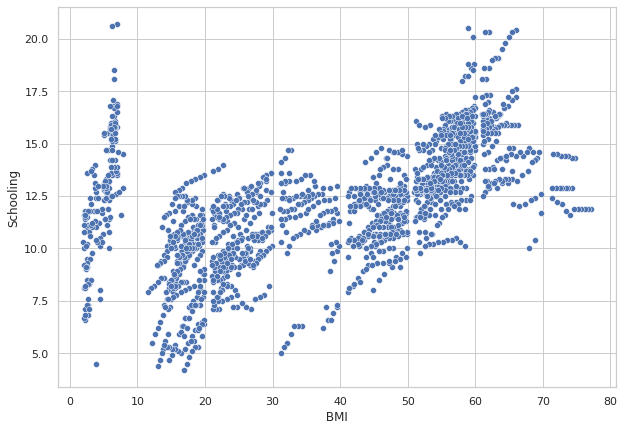

In [ ]:
fig = sns.scatterplot(
    data=life_expectancy_df,
    x = " BMI ",
    y="Schooling"
)

In [ ]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    life_expectancy_df[[" BMI "]], 
    life_expectancy_df[["Schooling"]], 
    test_size=test_size, 
    random_state=random_state
)

### Linear Regression for comparison

In [ ]:
scaler = StandardScaler()
lm = linear_model.LinearRegression()

In [ ]:
# define steps
steps = [
    ('scaler', scaler), 
    ('lm', lm)
]

# create pipeline from steps list
pipe = Pipeline(steps)

# fit model
pipe.fit(X_train, y_train)

# predict
y_pred = pipe.predict(X_test)

# The coefficient of determination: 1 is perfect prediction
print(f"Coefficient of determination: {r2_score(y_test.to_numpy(), y_pred )}")

Coefficient of determination: 0.3005073212829473


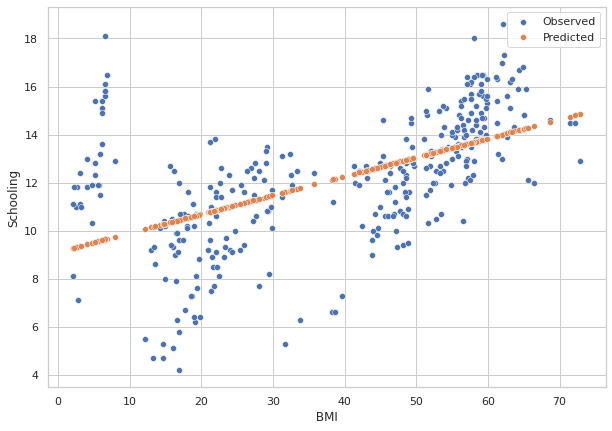

In [ ]:
# plot test results
predicted_df = pd.DataFrame({"Predicted": y_pred.ravel()}, index=X_test.index)
test_data_df = pd.concat([X_test, y_test, predicted_df], axis=1)

sns.scatterplot(data=test_data_df, x = " BMI ", y = "Schooling", label ="Observed") # observed
sns.scatterplot(data=test_data_df, x = " BMI ", y = "Predicted", label = "Predicted") # predicted

fig = plt.legend()

Notice, that on the above plot we do not "draw" the regression line directly.  Rather, we draw the predicted variables, and since they lie on the regression line, our predicted data form the regression line

Next, we're going to draw a line directly from its estimated coefficients: *intercept* and *slope*.

In [ ]:
# extract the linear regressor
estimator = pipe[-1]
print(estimator)

# extract intercept
intercept = estimator.intercept_
print(f"Intercept: {intercept}")

# extract slope
slope = estimator.coef_.ravel()
print(f"Slope: {slope}")

LinearRegression()
Intercept: [12.10341168]
Slope: [1.56403888]


In [ ]:
# create 100 x-es from X_test min to X_test max
X = np.linspace(X_test.min(),X_test.max(),100)
# calculate y accodring to the coeffs
y = intercept + X*slope

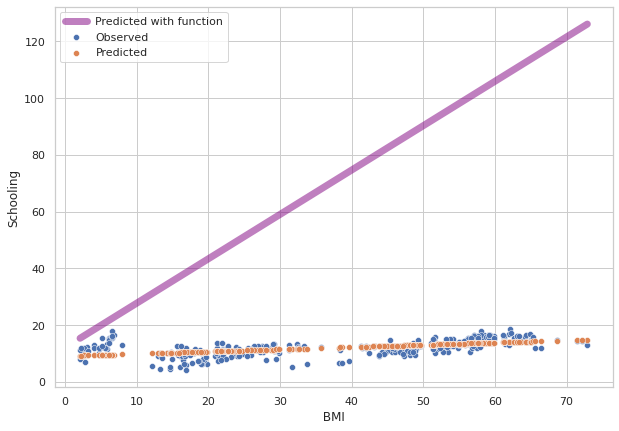

In [ ]:
# create 100 x-es from X_test min to X_test max
X = np.linspace(X_test.min(),X_test.max(),100)

# calculate y accodring to the coeffs
y = intercept + X*slope

# insert X and y to the df
function_data_df = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1)
# add column names
function_data_df.columns=["X", "y"]

# plot results
sns.scatterplot(data = test_data_df, x = " BMI ", y = "Schooling", label="Observed") # observed
sns.scatterplot(data=test_data_df, x = " BMI ", y = "Predicted", label="Predicted") # predicted
fig = sns.lineplot(data = function_data_df, 
             x = "X", 
             y = "y", 
             color="purple", 
             alpha=0.5, 
             linewidth=7,
             label = "Predicted with function"
             ) # predicted with coeffs

fig = plt.legend()

Something goes wrong... Our line clearly do not fit the data :(

Before you go any further, try to answer the question, what happened?

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


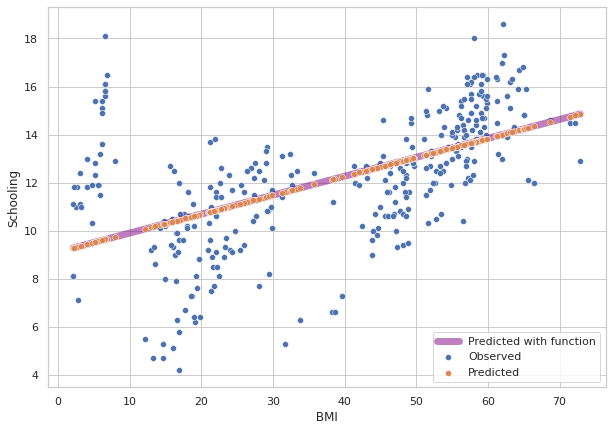

In [ ]:
# create 100 x-es from X_test min to X_test max
X = np.linspace(X_test.min(),X_test.max(),100)

scaler = pipe[0]
X_scaled = scaler.transform(X)

# calculate y accodring to the coeffs
y = intercept + X_scaled*slope

# insert X and y to the df
function_data_df = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1)
function_data_df.columns=["X", "y"]

# plot results
sns.scatterplot(data = test_data_df, x = " BMI ", y = "Schooling", label="Observed") # observed
sns.scatterplot(data=test_data_df, x = " BMI ", y = "Predicted", label="Predicted", zorder=4) # predicted
sns.lineplot(data = function_data_df, 
             x = "X", 
             y = "y", 
             color="purple", 
             alpha=0.5, 
             linewidth=7,
             label = "Predicted with function"
             )

fig = plt.legend()

Can you now tell what was wrong in the previous code?

### 1. Support Vector Machines

Before we move towards estimating BMI ~ Schooling effect, we're going to see the documentation of [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) in scikit-learn. You should ALWAYS check the documentation prior to using given method. They shouldn't be treated as black-boxes!

We move code for evaluation of models and for plotting results to avoid repeating code:

In [ ]:
def evaluate_model(pipe, X_train, y_train, X_test, y_test):
  '''
  Takes Pipeline model, train and test data. 
  Fit model and evaluate it on test data.
  '''

  # fit model
  # .ravel() flattens array into 1D - we ensure that y is (n_samples,)
  pipe.fit(X_train, y_train.to_numpy().ravel())

  # predict test data
  y_pred = pipe.predict(X_test)

  # predict train data
  y_train_pred = pipe.predict(X_train)

  # The coefficient of determination: 1 is perfect prediction
  print(f"Coefficient of determination: {r2_score(y_test, y_pred )}")

  return y_pred, y_train_pred

In [ ]:
def plot_svr(pipe, X_train, y_train, y_train_pred):
  '''
  Takes Pipeline model, train and predicted train data. 
  Plot train observed vs train predicted with support vectors 
  '''
  svr = pipe[-1]
  # extract indices of support vectors
  sv_ind = svr.support_

  predicted_train_df = pd.DataFrame({"Predicted": y_train_pred.ravel()}, index=X_train.index)
  train_data_df = pd.concat([X_train, y_train, predicted_train_df], axis=1)

  # extract indexes from indices
  support_indexes = train_data_df.iloc[sv_ind].index
  non_support_indexes = X_train.index.difference(support_indexes)

  # mark which observations are support vectors
  train_data_df.loc[support_indexes, 'Support'] = "Support Vector"
  train_data_df.loc[non_support_indexes, 'Support'] = "Data within tube"

  # observed data: support vectors and other data                  
  sns.scatterplot(data = train_data_df, 
                  x = " BMI ", 
                  y = "Schooling", 
                  hue = 'Support',
                  hue_order = ['Support Vector', "Data within tube"],
                  zorder=3,
                  legend='full'
                  )
  
  # predicted data
  sns.lineplot(data = train_data_df, 
                    x = " BMI ", 
                    y = "Predicted", 
                    color="purple", 
                    alpha=0.5, 
                    linewidth=7,
                    label="Predicted"
                    )
  plt.show()

In [ ]:
def plot_predicted(X_test, y_test, y_pred):
  '''
  Takes test and predicted data. 
  Plot test observed vs test predicted 
  '''
  predicted_df = pd.DataFrame({"Predicted": y_pred.ravel()}, index=X_test.index)
  test_data_df = pd.concat([X_test, y_test, predicted_df], axis=1)

  sns.scatterplot(data=test_data_df, x = " BMI ", y = "Schooling", label ="Observed") # observed
  sns.scatterplot(data=test_data_df, x = " BMI ", y = "Predicted", label = "Predicted") # predicted

  fig = plt.legend()

1.1 Linear

- $\text{epsilon} = 0.1$
- $C = 0.0001$ (close to hard margins)

In [ ]:
# create object of linear SVR model
svr_linear = SVR(kernel='linear', epsilon=0.1, C=0.0001)

# define steps
steps = [
    ('scaler', scaler), 
    ('svr', svr_linear)
]

# create pipeline from steps list
pipe = Pipeline(steps)

In [ ]:
y_pred, y_train_pred = evaluate_model(pipe, X_train, y_train, X_test, y_test)

Coefficient of determination: 0.02405437634441221


Plot test results

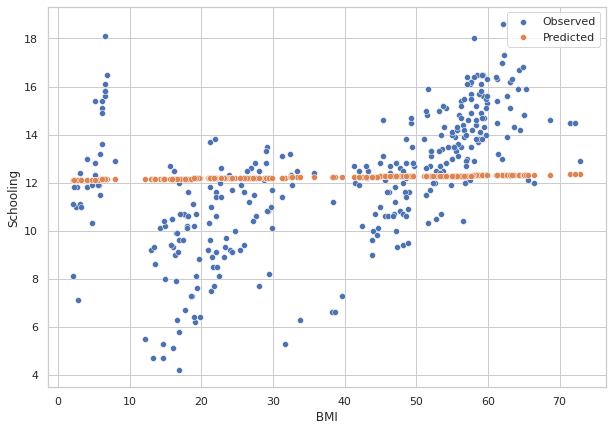

In [ ]:
plot_predicted(X_test, y_test, y_pred)

Plot train data with support vectors

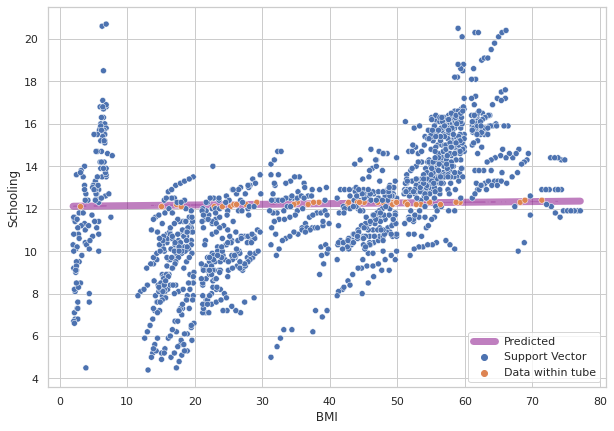

In [ ]:
plot_svr(pipe, X_train, y_train, y_train_pred)

- $\text{epsilon} = 0.1$
- $C = 1.0$ (soft margins)

In [ ]:
# create object of linear SVR model
svr_linear = SVR(kernel='linear', epsilon=0.1, C=1.0)

# define steps
steps = [
    ('scaler', scaler), 
    ('svr', svr_linear)
]

# create pipeline from steps list
pipe = Pipeline(steps)

In [ ]:
y_pred, y_train_pred = evaluate_model(pipe, X_train, y_train, X_test, y_test)

Coefficient of determination: 0.29437314203864495


Plot test results

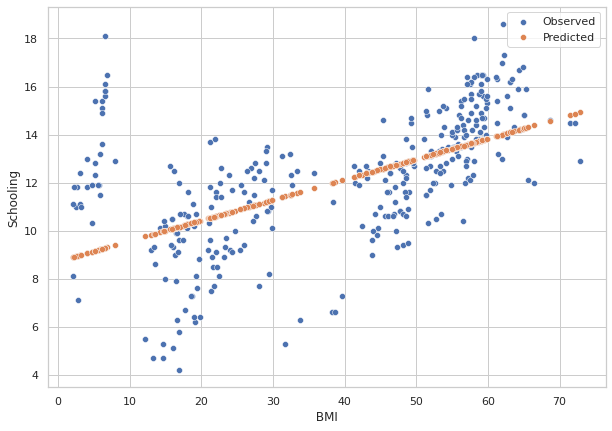

In [ ]:
plot_predicted(X_test, y_test, y_pred)

Plot train data with support vectors

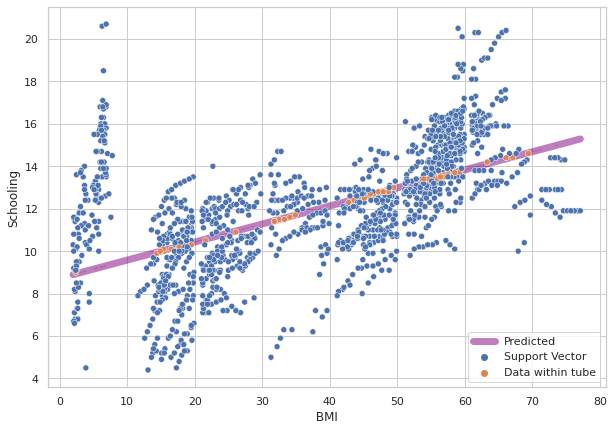

In [ ]:
plot_svr(pipe, X_train, y_train, y_train_pred)

Enlarge the epsilon-tube: 
- $\text{epsilon} = 2$
- $C = 1.0$ (soft margins)

In [ ]:
# create object of SVR model
svr_linear = SVR(kernel='linear', epsilon=2, C=1.0)

# define steps
steps = [
    ('scaler', scaler), 
    ('svr', svr_linear)
]

# create pipeline from steps list
pipe = Pipeline(steps)

In [ ]:
y_pred, y_train_pred = evaluate_model(pipe, X_train, y_train, X_test, y_test)

Coefficient of determination: 0.29897678118814275


Plot test results

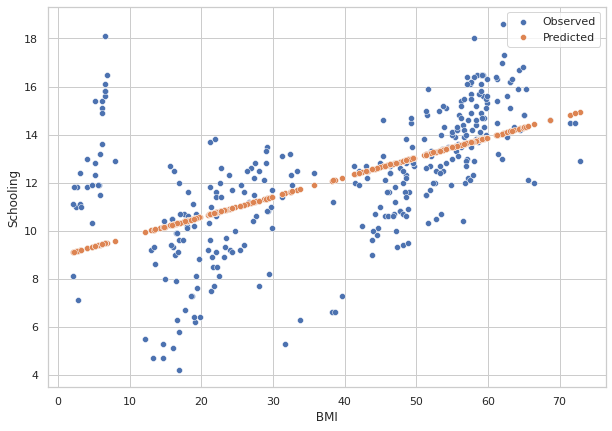

In [ ]:
plot_predicted(X_test, y_test, y_pred)

Plot train data with support vectors

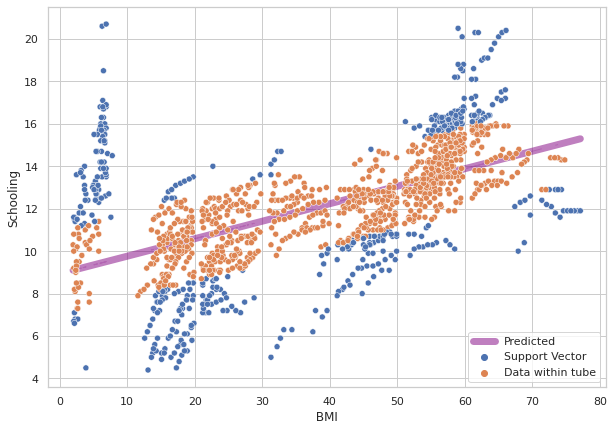

In [ ]:
plot_svr(pipe, X_train, y_train, y_train_pred)

- nonlinear: **RBF kernel**

In [ ]:
# create object of SVR model
svm = SVR(kernel='rbf', epsilon=2, C=1.0)

# define steps
steps = [
    ('scaler', scaler), 
    ('svm', svm)
]

# create pipeline from steps list
pipe = Pipeline(steps)

In [ ]:
y_pred, y_train_pred = evaluate_model(pipe, X_train, y_train, X_test, y_test)

Coefficient of determination: 0.5263364573031379


Plot test results

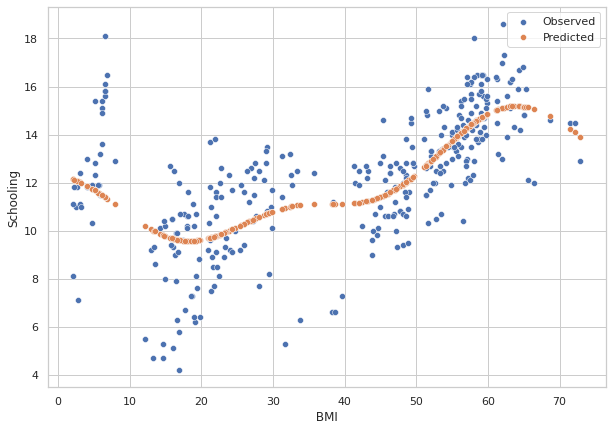

In [ ]:
plot_predicted(X_test, y_test, y_pred)

Plot train data with support vectors

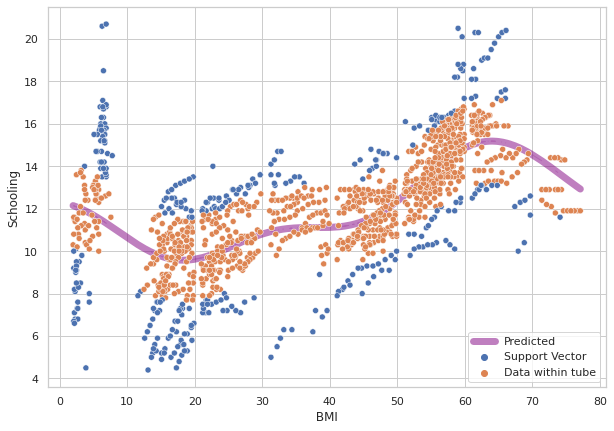

In [ ]:
plot_svr(pipe, X_train, y_train, y_train_pred)

### 2. K-Nearest Neighbours

In [ ]:
# create object of KNN model
knn = KNeighborsRegressor()

# define steps
steps = [
    ('scaler', scaler), 
    ('knn', knn)
]

# create pipeline from steps list
pipe = Pipeline(steps)

In [ ]:
y_pred, y_train_pred = evaluate_model(pipe, X_train, y_train, X_test, y_test)

Coefficient of determination: 0.5264795569553249


Plot test results

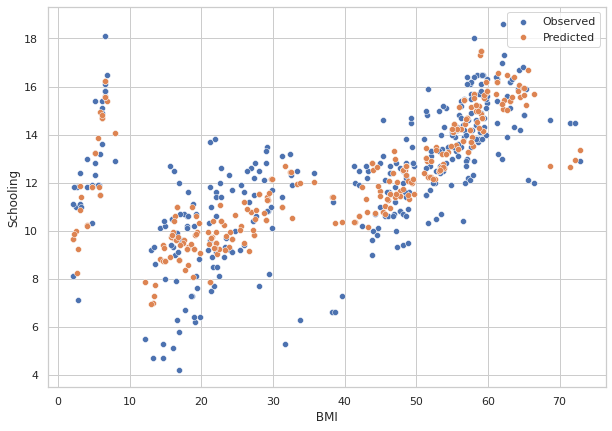

In [ ]:
plot_predicted(X_test, y_test, y_pred)

### 3. Decision Trees

In [ ]:
tree = DecisionTreeRegressor()

# define steps
steps = [
    ('scaler', scaler), 
    ('tree', tree)
]

# create pipeline from steps list
pipe = Pipeline(steps)

In [ ]:
y_pred, y_train_pred = evaluate_model(pipe, X_train, y_train, X_test, y_test)

Coefficient of determination: 0.4305196037608069


Plot test results

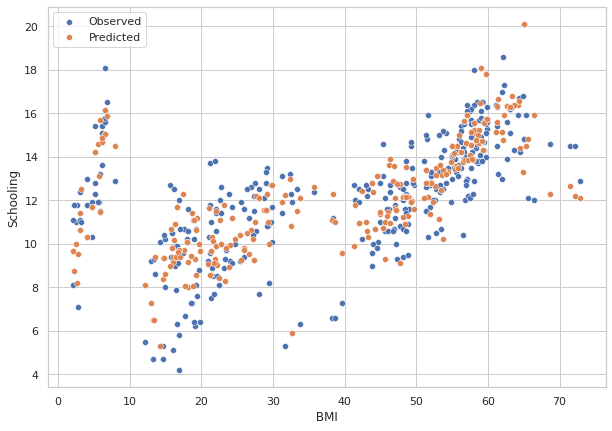

In [ ]:
plot_predicted(X_test, y_test, y_pred)

# TODO 🔥

1. Make your own copy of the notebook [Class_04_perfectionism.ipynb](https://github.com/abelowska/eegML/blob/main/Classes_04_perfectionism.ipynb) - from now it will be your `workbook` in which you will develop your *perfectionism project*. Name it in some meaningful way, such as. *Perfectionism_project.ipynb*.

2. Similar to the homework assignment in *Classes_03_simple_regression_on_perfectionism.ipynb*, prepare EEG data in the ERP-way: 
  - select one electrode;
  - select time window 0-100 ms;
  - average data in selected time window;

  At this point, your X set has only one feature: the average aplitude over the 0-100ms time window on a given electrode.

3. Model the data using three regressors:
  - Linear Regression;
  - KNN;
  - SVR with both linear and rbf kernels.

  Do not forget scale your data befor training. Use `Pipeline` to chain `Scaler` and `Regressor`.

  **You can play with the SVR and test various C and epsilon values :)**